In [6]:
import logging

import mrcfile
import numpy as np

from aspire.basis import FFBBasis2D, FSPCABasis
from aspire.classification import RIRClass2D
from aspire.image import Image
from aspire.operators import ScalarFilter

from aspire.covariance import RotCov2D

# from aspire.source import ArrayImageSource # Helpful hint if you want to BYO array.
from aspire.source import Simulation
from aspire.volume import Volume

logger = logging.getLogger(__name__)

In [2]:
##################################################
# Parameters
RESOLUTION = 64  # 300 used in paper (but needs a higher res source)
NUMBER_OF_TEST_IMAGES = 4096  # 24000 images in paper, 4096 is sufficient for clean dev.
DTYPE = np.float64
noise = 0 #0.01 # zero for clean, 0.001 for dirty 0.1 static

2021-06-10 17:07:25,692 INFO Appending a NoiseAdder to generation pipeline
2021-06-10 17:07:25,696 INFO Trying NFFT backend finufft
2021-06-10 17:07:25,703 INFO NFFT backend finufft usable.
2021-06-10 17:07:25,704 INFO Trying NFFT backend cufinufft
2021-06-10 17:07:25,705 INFO NFFT backend cufinufft not usable:
	No module named 'pycuda'
2021-06-10 17:07:25,706 INFO Trying NFFT backend pynfft
2021-06-10 17:07:25,708 INFO NFFT backend pynfft not usable:
	No module named 'pynfft'
2021-06-10 17:07:25,708 INFO Selected NFFT backend = finufft.
2021-06-10 17:07:26,198 INFO Applying forward transformations in pipeline
2021-06-10 17:07:26,198 INFO All forward transformations applied
2021-06-10 17:07:26,199 INFO Loaded 10 images


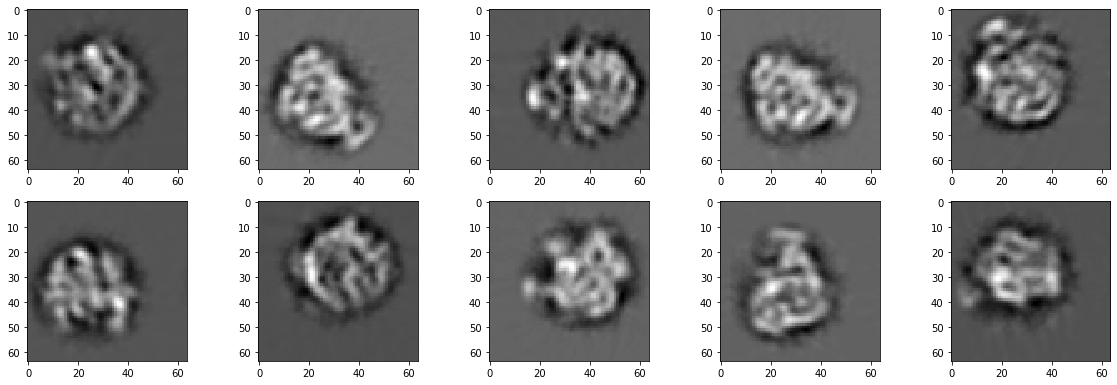

In [3]:
# Generate some projections downsampled to RESOLUTION
fh = mrcfile.open("../data/clean70SRibosome_vol_65p.mrc")  # ASPIRE_ROOT/tutorials/data/
v = Volume(fh.data.astype(DTYPE))
v = v.downsample((RESOLUTION,) * 3)

noise_var = noise * np.var(np.sum(v[0],axis=0))
noise_filter = ScalarFilter(dim=2, value=noise_var)

src = Simulation(
    L=v.resolution,
    n=NUMBER_OF_TEST_IMAGES,
    vols=v,
    dtype=DTYPE,
    noise_filter=noise_filter,
)
src.images(0, 10).show()

In [4]:
logger.info("Setting up FFB")
# Setup a Basis
basis = FFBBasis2D((RESOLUTION, RESOLUTION), dtype=DTYPE)
coefs = basis.evaluate_t(src.images(0, NUMBER_OF_TEST_IMAGES))

2021-06-10 17:07:35,981 INFO Setting up FFB
2021-06-10 17:07:35,984 INFO Expanding 2D image in a frequency-domain Fourier–Bessel basis using the fast method.
2021-06-10 17:07:59,783 INFO Applying forward transformations in pipeline
2021-06-10 17:07:59,784 INFO All forward transformations applied
2021-06-10 17:07:59,784 INFO Loaded 4096 images


In [5]:
coefs_complex = basis.to_complex(coefs)

In [8]:
cov2d = RotCov2D(basis)
mean_coef_est = cov2d.get_mean(coefs)
covar_coef_est = cov2d.get_covar(coefs, mean_coeff=mean_coef_est, noise_var=0).dense()

In [10]:
mean_coef_complex_est = basis.to_complex(mean_coef_est)
coefs_complex_centered = coefs_complex - mean_coef_complex_est
covar_coef_complex_est = np.real(np.conj(coefs_complex_centered.T) @ coefs_complex_centered) / src.n

In [12]:
ind = (basis.angular_indices == 0)
indc = (basis.complex_angular_indices == 0)

print(np.linalg.norm(covar_coef_est[ind, ind] - covar_coef_complex_est[indc, indc]))

9.863635648789244e-24


In [18]:
ell = 3

ind = (basis.angular_indices == ell) & (basis._indices['sgns'] == 1)
indc = (basis.complex_angular_indices == ell)

print(np.linalg.norm(covar_coef_est[ind, ind] / 2 - covar_coef_complex_est[indc, indc]))

ind = (basis.angular_indices == ell) & (basis._indices['sgns'] == -1)
indc = (basis.complex_angular_indices == ell)
print(np.linalg.norm(covar_coef_est[ind, ind] / 2 - covar_coef_complex_est[indc, indc]))

3.642890698764528e-24
3.642890698764528e-24


In [19]:
fspca_basis = FSPCABasis(src, basis)
fspca_basis.build(coefs)

2021-06-10 17:14:44,700 INFO Estimate the noise of images using anisotropic method.
2021-06-10 17:14:47,742 INFO Applying forward transformations in pipeline
2021-06-10 17:14:47,742 INFO All forward transformations applied
2021-06-10 17:14:47,743 INFO Loaded 512 images
2021-06-10 17:14:50,975 INFO Applying forward transformations in pipeline
2021-06-10 17:14:50,976 INFO All forward transformations applied
2021-06-10 17:14:50,977 INFO Loaded 512 images
2021-06-10 17:14:54,213 INFO Applying forward transformations in pipeline
2021-06-10 17:14:54,213 INFO All forward transformations applied
2021-06-10 17:14:54,214 INFO Loaded 512 images
2021-06-10 17:14:57,511 INFO Applying forward transformations in pipeline
2021-06-10 17:14:57,512 INFO All forward transformations applied
2021-06-10 17:14:57,515 INFO Loaded 512 images
2021-06-10 17:15:00,764 INFO Applying forward transformations in pipeline
2021-06-10 17:15:00,765 INFO All forward transformations applied
2021-06-10 17:15:00,765 INFO Load

In [21]:
fspca_basis.spca_coef.shape

(4096, 2474)

In [38]:
spca_coefs = fspca_basis.expand(coefs)
coefs1 = fspca_basis.evaluate(spca_coefs)

print(np.linalg.norm(coefs - coefs1))

1.142136528445003e-16


In [37]:
print(np.linalg.norm(spca_coefs - fspca_basis.spca_coef))

0.0011934888400001145
